<a href="https://colab.research.google.com/github/deepw02/comp3931-sc20dpw/blob/main/pm_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Process Mining/Machine Learning to Predict Diagnosis ICD codes


### Authentication & Connecting to MIMIC-III

In [ ]:
!pip install -U pm4py

from google.colab import auth
from google.cloud import bigquery
from google.colab import drive

import pandas as pd
import numpy as np
import sys
import pm4py

from pm4py.algo.discovery.heuristics import algorithm as heuristic_miner
from pm4py.visualization.heuristics_net import visualizer as heuristic_visualizer

from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import matthews_corrcoef

from matplotlib import pyplot as plt

auth.authenticate_user()
client = bigquery.Client(project='physionet-data-369222')
drive.mount('drive')

### Load Dataframes from Google Drive

In [3]:
cardiovascular = pd.read_csv('drive/My Drive/comp3931-sc20dpw/cardiovascular.csv')
filtered_cardiovascular = pd.read_csv('drive/My Drive/comp3931-sc20dpw/filtered_cardiovascular.csv')
filtered_cardiovascular['duration'] = filtered_cardiovascular[['duration']].apply(pd.to_timedelta)
admissions = pd.read_csv('drive/My Drive/comp3931-sc20dpw/admissions.csv')
discharges = pd.read_csv('drive/My Drive/comp3931-sc20dpw/discharges.csv')
freq_procedures = pd.read_csv('drive/My Drive/comp3931-sc20dpw/freq_procedures.csv')
procedures = pd.read_csv('drive/My Drive/comp3931-sc20dpw/procedures.csv')
freq_cont_procedures = pd.read_csv('drive/My Drive/comp3931-sc20dpw/freq_cont_procedures.csv')
cont_procedures = pd.read_csv('drive/My Drive/comp3931-sc20dpw/cont_procedures.csv')
freq_labtests = pd.read_csv('drive/My Drive/comp3931-sc20dpw/freq_labtests.csv')
labtests = pd.read_csv('drive/My Drive/comp3931-sc20dpw/labtests.csv')
icustays = pd.read_csv('drive/My Drive/comp3931-sc20dpw/icustays.csv')

event_log = pd.read_csv('drive/My Drive/comp3931-sc20dpw/event_log.csv')
event_log['timestamp'] = event_log[['timestamp']].apply(pd.to_datetime)
event_log['outtime'] = event_log[['outtime']].apply(pd.to_datetime)
event_log['duration_td'] = event_log[['duration_td']].apply(pd.to_timedelta)

feature_data_0 = pd.read_csv('drive/My Drive/comp3931-sc20dpw/feature_data_0.csv')
feature_data_25 = pd.read_csv('drive/My Drive/comp3931-sc20dpw/feature_data_25.csv')
feature_data_50 = pd.read_csv('drive/My Drive/comp3931-sc20dpw/feature_data_50.csv')
feature_data_75 = pd.read_csv('drive/My Drive/comp3931-sc20dpw/feature_data_75.csv')
feature_data_100 = pd.read_csv('drive/My Drive/comp3931-sc20dpw/feature_data_100.csv')

target_data = pd.read_csv('drive/My Drive/comp3931-sc20dpw/target_data.csv')

hadm_unique = tuple((filtered_cardiovascular.hadm_id.tolist()))
freq_procedures_list = freq_procedures.label.tolist()
freq_cont_procedures_list = freq_cont_procedures.label.tolist()
freq_labtests_list = freq_labtests.label.tolist()
hadm_ordered = event_log['hadm_id'].unique().tolist()

### Event Log Creation

In [ ]:
# Function to filter out records where age > 100 during admission

def filter_age(df):

  filter_age_query = (f'''
    SELECT
      hadm_id
    FROM
      physionet-data.mimiciii_clinical.admissions,
      physionet-data.mimiciii_clinical.patients
    WHERE
      admissions.subject_id = patients.subject_id AND
      hadm_id in {tuple(df.hadm_id.tolist())} AND
      DATE_DIFF(admittime, dob, year) <= 100
  ''')

  result = client.query(filter_age_query).to_dataframe()

  return df[df.hadm_id.isin(result.hadm_id)]

In [ ]:
# Function to filter out records that have don't include any procedures

def filter_procedures(df):
   
  filter_procedures_query = (f'''
    SELECT
      hadm_id
    FROM
      physionet-data.mimiciii_clinical.procedureevents_mv
    WHERE
      hadm_id in {tuple(df.hadm_id.tolist())}
    GROUP BY
      hadm_id
  ''')
  
  result = client.query(filter_procedures_query).to_dataframe()

  return df[df.hadm_id.isin(result.hadm_id)]

In [ ]:
# Function to filter out records that have discharge/death before admission

def filter_discharges(df):

  fiter_discharges_query = (f'''
  SELECT 
    hadm_id
  FROM
    physionet-data.mimiciii_clinical.admissions
  WHERE
    hadm_id in {tuple(df.hadm_id.tolist())} AND
    dischtime <= admittime
  ''')

  result = client.query(fiter_discharges_query).to_dataframe()

  return df[~df.hadm_id.isin(result.hadm_id)]

In [ ]:
# Extracting subject_id, hadm_id & ICD-9 codes of cardiovascular patients

cardiovascular_query = ('''
  SELECT
    hadm_id,
    icd9_code
  FROM
    physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE
    icd9_code BETWEEN '390%' AND '459%' AND
    seq_num = 1
''')

cardiovascular = client.query(cardiovascular_query).to_dataframe()

cardiovascular['icd9_code'] = cardiovascular[['icd9_code']].apply(pd.to_numeric)

In [ ]:
# Filter cardiovascular patient records

# Remove records with abnormal ages
filtered_cardiovascular = filter_age(cardiovascular)

# Remove records without any procedures
filtered_cardiovascular = filter_procedures(filtered_cardiovascular)

# Remove records with death/discharge before admission
filtered_cardiovascular = filter_discharges(filtered_cardiovascular)

# Sorting values by hadm_id
filtered_cardiovascular.sort_values(['hadm_id'], inplace=True)

# Reset dataframe index
filtered_cardiovascular.reset_index(drop=True, inplace=True)

# List of hadm_ids
hadm_unique = tuple((filtered_cardiovascular.hadm_id.tolist()))

In [ ]:
# Creating admissions event log

admissions_query = (f'''
  SELECT 
    hadm_id,
    "Admission" as event,
    admittime as timestamp,
    admission_type,
    DATE_DIFF(admittime, dob, year) as age,
    gender
  FROM
    physionet-data.mimiciii_clinical.admissions,
    physionet-data.mimiciii_clinical.patients
  WHERE
    hadm_id IN {hadm_unique} AND
    admissions.subject_id = patients.subject_id
''')

admissions = client.query(admissions_query).to_dataframe()

In [ ]:
# Creating discharge/death event log

discharges_query = (f'''
    SELECT
      hadm_id,
      IF(deathtime IS NOT NULL, "Death", "Discharge") as event,
      dischtime as timestamp,
      IF(deathtime IS NOT NULL, 1, 0) as expire_flag
    FROM 
      physionet-data.mimiciii_clinical.admissions
    WHERE
    hadm_id IN {hadm_unique}
''')

discharges = client.query(discharges_query).to_dataframe()

In [ ]:
# Query to find n most frequent (non-continuous) procedures conducted on cardiovascular patients

num_procedures = 2

freq_procedures_query = (f'''
  SELECT
    LOWER(REPLACE(label, ' ', '_')) as label,
    COUNT(*) as count_procedures   
  FROM
    physionet-data.mimiciii_clinical.procedureevents_mv as p,
    physionet-data.mimiciii_clinical.d_items as d
  WHERE
    d.itemid = p.itemid AND
    hadm_id in {hadm_unique} AND
    starttime <= endtime
  GROUP BY
    label
  HAVING
    AVG(DATETIME_DIFF(endtime, starttime, minute)) = 1
  ORDER BY
    count_procedures DESC
  LIMIT
    {num_procedures}
''')

freq_procedures = client.query(freq_procedures_query).to_dataframe()
freq_procedures_list = freq_procedures.label.tolist()

In [ ]:
# Creating (non-continuous) procedures event log

procedures_query = (f'''
    SELECT
      hadm_id,
      "Procedure" as event,
      starttime as timestamp,
      LOWER(REPLACE(label, ' ', '_')) as label
    FROM
      physionet-data.mimiciii_clinical.procedureevents_mv as p,
      physionet-data.mimiciii_clinical.d_items as d
    WHERE
      p.itemid = d.itemid AND
      hadm_id in {hadm_unique} AND
      LOWER(REPLACE(label, ' ', '_')) in {tuple(freq_procedures.label.tolist())} AND
      starttime <= endtime
''')

procedures = client.query(procedures_query).to_dataframe()

In [ ]:
# Query to find n most frequent continuous procedures conducted on cardiovascular patients

num_cont_procedures = 3

freq_cont_procedures_query = (f'''
  SELECT
    LOWER(REPLACE(ordercategoryname, ' ', '_')) as label,
    COUNT(*) as count_procedures    
  FROM
    physionet-data.mimiciii_clinical.procedureevents_mv
  WHERE
    hadm_id in {hadm_unique} AND
    starttime <= endtime
  GROUP BY
    ordercategoryname
  HAVING
    AVG(DATETIME_DIFF(endtime, starttime, minute)) > 1
  ORDER BY
    count_procedures DESC
  LIMIT
    {num_cont_procedures}
''')

freq_cont_procedures = client.query(freq_cont_procedures_query).to_dataframe()
freq_cont_procedures_list = freq_cont_procedures.label.tolist()

In [ ]:
# Creating continuous procedures event log

cont_procedures_query = (f'''
  SELECT
      hadm_id,
      "Procedure" as event,
      starttime as timestamp,
      DATETIME_DIFF(endtime, starttime, minute) as duration,
      LOWER(REPLACE(ordercategoryname, ' ', '_')) as label
    FROM
      physionet-data.mimiciii_clinical.procedureevents_mv
    WHERE
      hadm_id in {hadm_unique} AND
      LOWER(REPLACE(ordercategoryname, ' ', '_')) in {tuple(freq_cont_procedures.label.tolist())} AND
      starttime <= endtime
''')

cont_procedures = client.query(cont_procedures_query).to_dataframe()

In [ ]:
# Query to find n most frequent lab tests conducted on cardiovascular patients

num_labtests = 2

freq_labtests_query = (f'''
  SELECT
    lab.itemid,
    COUNT(*) as count_labtests,
    LOWER(REPLACE(label, ' ', '_')) as label
  FROM
    physionet-data.mimiciii_clinical.labevents as lab,
    physionet-data.mimiciii_clinical.d_labitems as d
  WHERE
    hadm_id in {hadm_unique} AND
    lab.itemid = d.itemid
  GROUP BY
    lab.itemid,
    label
  ORDER BY
    count_labtests DESC
  LIMIT
    {num_labtests}
''')

freq_labtests = client.query(freq_labtests_query).to_dataframe()
freq_labtests_list = freq_labtests.label.tolist()

In [ ]:
# Creating lab tests event log

labtests_query = (f'''
  SELECT
    hadm_id,
    "Labtest" as event,
    charttime as timestamp,
    LOWER(REPLACE(label, ' ', '_')) as label,
    IF(FLAG = "abnormal", "abnormal", "normal") as flag
  FROM
    physionet-data.mimiciii_clinical.labevents as lab,
    physionet-data.mimiciii_clinical.d_labitems as d
  WHERE
    hadm_id IN {hadm_unique} AND
    lab.itemid = d.itemid AND
    lab.itemid IN {tuple(freq_labtests.itemid.tolist())} AND
    valuenum IS NOT NULL
''')

labtests = client.query(labtests_query).to_dataframe()

In [ ]:
# Creating ICU stays event log

icustays_query = (f'''
  SELECT
    hadm_id,
    "ICU" as event,
    intime as timestamp,
    los as duration,
    outtime
  FROM
    physionet-data.mimiciii_clinical.transfers
  WHERE
    hadm_id in {hadm_unique} AND
    curr_careunit LIKE "%CU%" AND
    los > 0''')

icustays =  client.query(icustays_query).to_dataframe()
icustays['duration_td'] = icustays[['duration']].apply(pd.to_timedelta, unit='h')

### Combining Event Logs

In [ ]:
# Checking if admissions & discharges table have hadm_id in the same order

def corr_check():

  if len(admissions) != len(discharges):
    return False

  for i in range(len(admissions)):
    if admissions.iloc[i].hadm_id != discharges.iloc[i].hadm_id:
      return False

  return True

corr = corr_check()

if not corr:
  sys.exit()

In [ ]:
# Concatenating event logs

event_log = pd.concat([admissions, procedures, cont_procedures, labtests, icustays, discharges], ignore_index=True)

event_log['timestamp'] = event_log[['timestamp']].apply(pd.to_datetime)
event_log['outtime'] = event_log[['outtime']].apply(pd.to_datetime)
event_log['duration_td'] = event_log[['duration_td']].apply(pd.to_timedelta)

event_log.sort_values(['hadm_id', 'timestamp'], inplace=True)

event_log.reset_index(drop=True, inplace=True)

hadm_ordered = event_log['hadm_id'].unique().tolist()

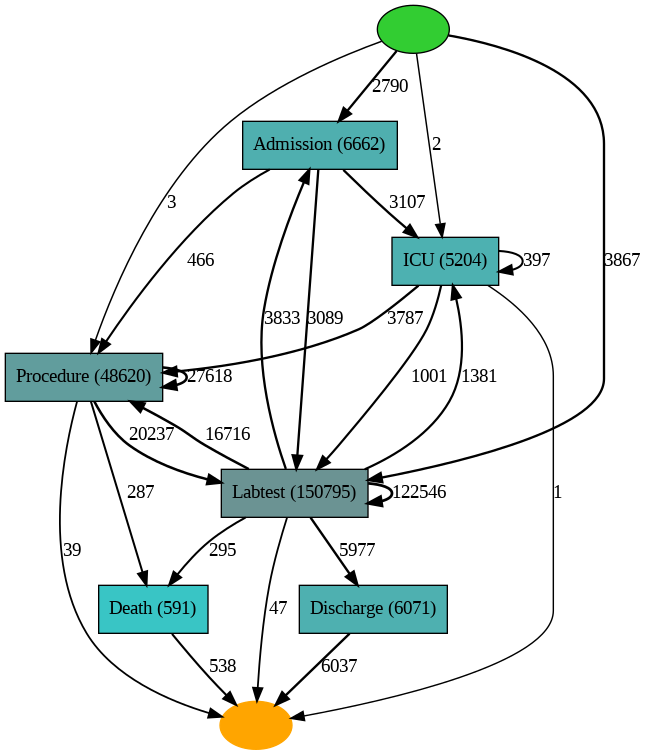

In [ ]:
# Discovering initial process model

for_discovery = event_log[['hadm_id', 'event', 'timestamp']].copy()
for_discovery.rename(columns={'hadm_id':'case:concept:name', 'event':'concept:name', 'timestamp':'time:timestamp'}, inplace=True)

heuristic_net = heuristic_miner.apply_heu(for_discovery)
viz = heuristic_visualizer.apply(heuristic_net)
heuristic_visualizer.view(viz)

In [ ]:
# Removing events after discharge/death

discharge_indices = event_log.index[(event_log['event'] == 'Discharge') | (event_log['event'] == 'Death')].tolist()

# hadm_ordered & discharge_indices SHOULD BE of same length
if len(discharge_indices) != len(hadm_ordered):
  sys.exit()

# Storing index of discharge/death corresponding to hadm_id
discharge_dict = {}
for i in range(len(hadm_ordered)):
  discharge_dict[hadm_ordered[i]] = discharge_indices[i]


offset = 1
mask = [True for i in range(len(event_log))]

# Building mask to drop rows after death/discharge
for hadm_id in discharge_dict:
  offset = 1
  
  while True:
    index = discharge_dict[hadm_id] + offset
    if index not in event_log.index:
      break

    row = event_log.loc[index]

    if row['hadm_id'] == hadm_id:
      mask[index] = False
      offset += 1
    else:
      break

  continue

# Applying mask to event log and resetting index
event_log = event_log[mask]
event_log.reset_index(drop=True, inplace=True)

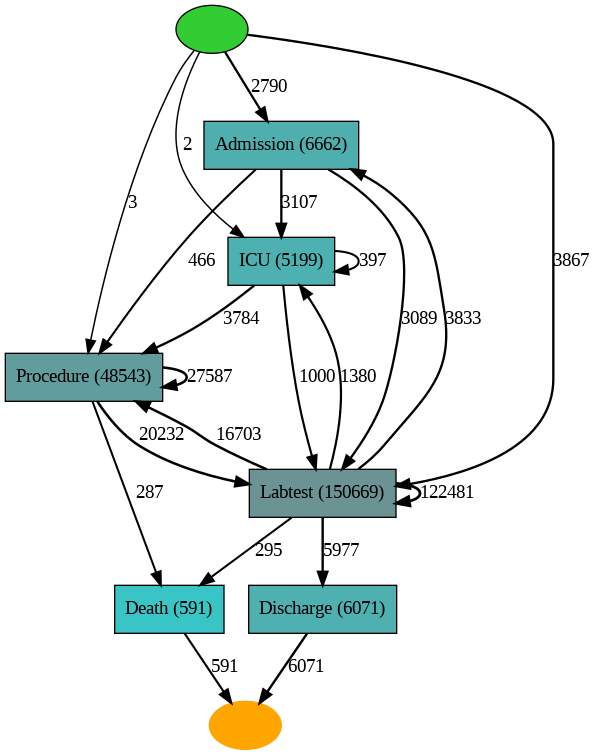

In [ ]:
# Discovering process model after removing events after death/discharge

for_discovery = event_log[['hadm_id', 'event', 'timestamp']].copy()
for_discovery.rename(columns={'hadm_id':'case:concept:name', 'event':'concept:name', 'timestamp':'time:timestamp'}, inplace=True)

heuristic_net = heuristic_miner.apply_heu(for_discovery)
viz = heuristic_visualizer.apply(heuristic_net)
heuristic_visualizer.view(viz)

In [ ]:
# Counting procedures and labtests for traces with time in event log
# Adding duration for continuous procedures & ICU stays for traces with time in event logs

for procedure in freq_procedures_list:
  event_log[f'count_{procedure}'] = 0

for cont_procedure in freq_cont_procedures_list:
  event_log[f'duration_{cont_procedure}'] = 0

for labtest in freq_labtests_list:
  event_log[f'count_normal_{labtest}'] = 0
  event_log[f'count_abnormal_{labtest}'] = 0

event_log['duration_icu'] = 0

temp_event_log = pd.DataFrame()

count_procedures = {}
duration_cont_procedures = {}
count_labtests = {}

duration_icu = pd.Timedelta(0, 'h')
cur_icu_outtime = pd.Timestamp(year=2002, month=11, day=14, hour=4, minute=20, second=17)
cur_icu_duration = pd.Timedelta(0, 'h')
icu_flag = False

# Count for every hadm_id
for hadm_id in hadm_ordered:

  for procedure in freq_procedures_list:
    count_procedures[f'count_{procedure}'] = 0

  for cont_procedure in freq_cont_procedures_list:
    duration_cont_procedures[f'duration_{cont_procedure}'] = 0

  for labtest in freq_labtests_list:
    count_labtests[f'count_normal_{labtest}'] = 0
    count_labtests[f'count_abnormal_{labtest}'] = 0

  duration_icu = pd.Timedelta(0, 'h')
  cur_icu_outtime = pd.Timestamp(year=2002, month=11, day=14, hour=4, minute=20, second=17)
  cur_icu_duration = pd.Timedelta(0, 'h')
  icu_flag = False
  
  records = event_log.loc[event_log['hadm_id'] == hadm_id]

  # Iterate over all events corresponding to a patient
  for index, row in records.iterrows():
    # Handle procedures & labtests
    # Check procedure/labtest for the current row
    if row['label'] in freq_procedures_list:
      count_procedures[f"count_{row['label']}"] += 1

    if row['label'] in freq_cont_procedures_list:
      duration_cont_procedures[f"duration_{row['label']}"] += row['duration']

    if row['label'] in freq_labtests_list:
      count_labtests[f"count_{row['flag']}_{row['label']}"] += 1

    # Write count/duration for procedures & labtests to the row
    for procedure in freq_procedures_list:
      records.at[index, f'count_{procedure}'] = count_procedures[f'count_{procedure}']

    for cont_procedure in freq_cont_procedures_list:
      records.at[index, f'duration_{cont_procedure}'] = duration_cont_procedures[f'duration_{cont_procedure}']

    for labtest in freq_labtests_list:
      records.at[index, f'count_normal_{labtest}'] = count_labtests[f'count_normal_{labtest}']
      records.at[index, f'count_abnormal_{labtest}'] = count_labtests[f'count_abnormal_{labtest}']
      
    # Handle ICU duration calculation
    # Check if a previous ICU stay has ended using current row's timestamp
    if row['timestamp'] > cur_icu_outtime:
      # Account for any remaining duration
      if cur_icu_duration > pd.Timedelta(0, 'h'):
        duration_icu += cur_icu_duration
      cur_icu_outtime = pd.Timestamp(year=2002, month=11, day=14, hour=4, minute=20, second=17)
      cur_icu_duration = pd.Timedelta(0, 'h')
      icu_flag = False      

    # Increase ICU duration upto current row & decrease remaining duration if trace is in ICU
    if icu_flag:
      duration_icu += records.at[index, 'timestamp'] - records.at[index-1, 'timestamp']
      cur_icu_duration -= records.at[index, 'timestamp'] - records.at[index-1, 'timestamp']

    # Set variables & flag if current row is an ICU transfer
    if row['event'] == "ICU":
      cur_icu_outtime = row['outtime']
      cur_icu_duration = row['duration_td']
      icu_flag = True

    # Wrtie ICU duration for current row
    records.at[index, 'duration_icu'] = duration_icu.total_seconds()/60

  temp_event_log = pd.concat([temp_event_log, records])

event_log = temp_event_log.copy()

In [ ]:
# Removing events before admission

admission_indices = event_log.index[(event_log['event'] == 'Admission')].tolist()

# hadm_ordered & admission_indices SHOULD BE of same length
if len(admission_indices) != len(hadm_ordered):
  sys.exit()

# Storing index of discharge/death corresponding to hadm_id
admission_dict = {}
for i in range(len(hadm_ordered)):
  admission_dict[hadm_ordered[i]] = admission_indices[i]

offset = 1
mask = [True for i in range(len(event_log))]

# Building mask to drop rows before admission
for hadm_id in admission_dict:
  offset = 1

  while True:
    index = admission_dict[hadm_id] - offset

    if index not in event_log.index:
      break

    row = event_log.loc[index]

    if row['hadm_id'] == hadm_id:
      mask[index] = False
      offset += 1
    else:
      break

  continue

# Applying mask to event log and resetting index
event_log = event_log[mask]
event_log.reset_index(drop=True, inplace=True)

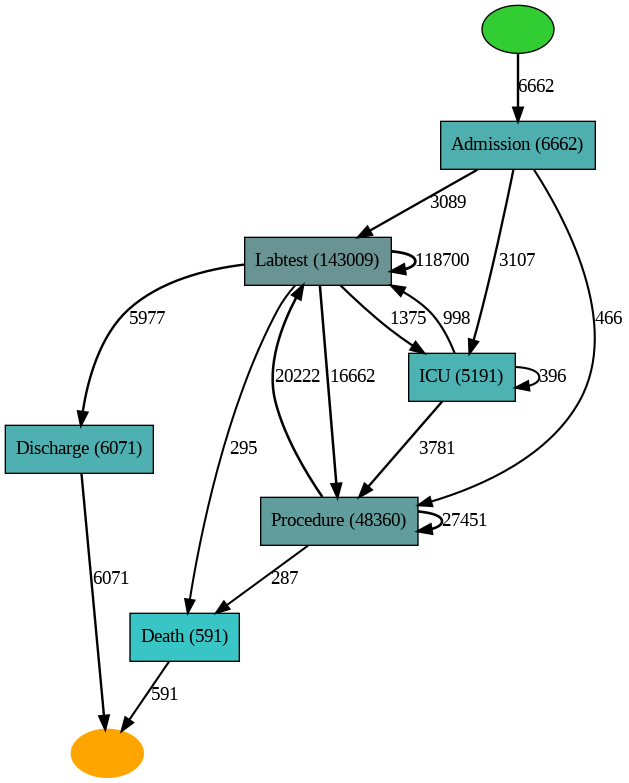

In [ ]:
# Discovering process model after removing events before admission

for_discovery = event_log[['hadm_id', 'event', 'timestamp']].copy()
for_discovery.rename(columns={'hadm_id':'case:concept:name', 'event':'concept:name', 'timestamp':'time:timestamp'}, inplace=True)

heuristic_net = heuristic_miner.apply_heu(for_discovery)  
viz = heuristic_visualizer.apply(heuristic_net)
heuristic_visualizer.view(viz)

In [ ]:
# Copying repetetive data

repetitive_list = ['admission_type', 'age', 'gender']

for hadm_id in hadm_ordered:
  mask = event_log.hadm_id == hadm_id
  for column in repetitive_list:
    event_log.loc[mask, column] = event_log[mask].iloc[0][column]

### Calulate duration for each trace

In [ ]:
# Calculating duration for each trace and storing in filtered_cardiovascular

for hadm_id in hadm_ordered:
  records = event_log[event_log['hadm_id'] == hadm_id]
  duration = records.iloc[-1].loc['timestamp'] - records.iloc[0].loc['timestamp']
  filtered_cardiovascular.loc[filtered_cardiovascular['hadm_id'] == hadm_id, 'duration'] = duration

### Prepare Feature Data

In [ ]:
# Function to get feature data at some % of trace

def get_feature_data(event_log, durations, percentage):
  pd.options.mode.chained_assignment = None
  feature_data = pd.DataFrame()

  # Sort event log & durations 
  event_log.sort_values(['hadm_id', 'timestamp'], inplace=True)
  event_log.reset_index(drop=True, inplace=True)
  durations.sort_values(['hadm_id'], inplace=True)
  durations.reset_index(drop=True, inplace=True)

  # Pre-calculate all boundaries in order
  admittimes = event_log[(event_log['event'] == 'Admission')]['timestamp'].tolist()
  boundaries = []
  for index, row in filtered_cardiovascular.iterrows():
    boundaries.append(admittimes[index] + ((percentage/100) * row['duration']))

  # Extract death/discharge indices from event log
  discharge_indices = event_log.index[(event_log['event'] == 'Discharge') | (event_log['event'] == 'Death')].tolist()
  
  i = 0 # current row in event_log
  hadm_indexer = 0 # current hadm_id number
  feature_rows = [0 for hadm_id in event_log.hadm_id.unique()] # list of relevant row indices

  while i < len(event_log):
    # Update relevant row index if within boundary  
    if event_log.iloc[i].loc['timestamp'] <= boundaries[hadm_indexer]:
      feature_rows[hadm_indexer] = i
      # Increment hadm_id number if crossed discharge
      
      if i in discharge_indices:
        hadm_indexer += 1
      
      i += 1
    # Jump to next trace if crossed boundary
    else:
      i = discharge_indices[hadm_indexer] + 1
      hadm_indexer += 1

  # Concatenate to feature_data
  for index in feature_rows:
    feature_data = pd.concat([feature_data, event_log.iloc[[index]].copy()])

  # Dropping unnecessary columns
  feature_data.reset_index(drop=True, inplace=True)
  feature_data.drop(columns=['hadm_id', 'event', 'timestamp', 'label', 'duration', 'flag', 'outtime', 'duration_td'], inplace=True)
  if percentage != 100:
    feature_data.drop(columns=['expire_flag'], inplace=True)

  pd.options.mode.chained_assignment = 'warn'
  return feature_data

In [ ]:
feature_data_0 = get_feature_data(event_log, filtered_cardiovascular[['hadm_id', 'duration']], 0)
feature_data_25 = get_feature_data(event_log, filtered_cardiovascular[['hadm_id', 'duration']], 25)
feature_data_50 = get_feature_data(event_log, filtered_cardiovascular[['hadm_id', 'duration']], 50)
feature_data_75 = get_feature_data(event_log, filtered_cardiovascular[['hadm_id', 'duration']], 75)
feature_data_100 = get_feature_data(event_log, filtered_cardiovascular[['hadm_id', 'duration']], 100)

### Prepare Target Data

In [ ]:
# Creating dataframe of ICD9-codes in required order

target_data = pd.DataFrame({'icd9_code': pd.Series(dtype=int)})

i = 0
for hadm_id in hadm_ordered:
  target_data.loc[i] = filtered_cardiovascular.loc[filtered_cardiovascular['hadm_id'] == hadm_id].iloc[0]['icd9_code']
  i += 1

# Keeping only first 3 digits of code
target_data['icd9_code'] = target_data['icd9_code'].astype(str).str[:3].astype(int)

### Train-Test Split & Apply Preprocessing Pipeline

In [4]:
# CODE TAKEN FROM COMP3611-ML_Pipeline_Part_2.ipynb
# Select columns from dataframe needed for preprocessing

class DataFrameSelector(BaseEstimator):
    
    def __init__(self, attribute_names):
        self.attribute_names= attribute_names
        
    def fit(self,X, y = None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values

In [5]:
def preprocess(df):
  # Defining numerical & categorical features
  cat_features = ['admission_type', 'gender']
  num_features = [feature for feature in list(df) if feature not in cat_features]
  
  # Creating numerical & categorical pipelines & combining the two
  num_pipeline = Pipeline([
      ('selector', DataFrameSelector(num_features)),
      ('std_scaler', StandardScaler())
  ])

  cat_pipeline = Pipeline([
      ('selector', DataFrameSelector(cat_features)),
      ('one_hot', OneHotEncoder())
  ])

  full_pipeline = FeatureUnion(transformer_list=[
      ("num_pipeline",num_pipeline),
      ("cat_pipeline",cat_pipeline)
  ])

  return full_pipeline.fit_transform(df)

In [6]:
# Function to train linear regressor, test model and print evaluation metrics

def linear_train_test(train_features, train_targets, test_features, test_targets, string, offset):
  lin_reg=LinearRegression()
  lin_reg.fit(train_features, train_targets['icd9_code'].to_numpy())

  test_predictions = (np.rint(lin_reg.predict(test_features))).astype(int)

  # Calculate accuracy allowing predicited value to be within a range of the true value
  count = 0
  for i in range(len(test_predictions)):
    target = test_targets['icd9_code'].to_numpy()[i]
    if test_predictions[i] in range((target - offset), (target + offset + 1)):
      count +=1

  # Calculate RMSE
  lin_mse = mean_squared_error(test_targets['icd9_code'].to_numpy(), test_predictions)
  lin_rmse=np.sqrt(lin_mse)

  # Calculate MCC
  mcc = matthews_corrcoef(test_targets['icd9_code'].to_numpy(), test_predictions)

  print(f'{string} score:-')
  print(f"Exact accuracy: {round(accuracy_score(test_targets['icd9_code'].to_numpy(), test_predictions), 5)}")
  print(f'Accuracy allowing +/- {offset}: {round(count/len(test_predictions), 5)}')
  print(f'Matthews correlation coefficient: {round(mcc, 5)}')
  print(f'RMSE: {round(lin_rmse, 5)}')
  print('------------------------')
  print('')

  return lin_reg

In [7]:
# Function to find best hyperparameters for random forest classifier

def find_classifier_hyperparameters(train_features, train_targets):

  rf = RandomForestClassifier(random_state=49)
  
  param_grid = [{"n_estimators": np.arange(100, 301, 50), "min_samples_split": np.arange(2, 11, 1), "bootstrap": [True, False]}]
  grid_search_forest = GridSearchCV(rf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
  grid_search_forest.fit(train_features, train_targets['icd9_code'].to_numpy())
  
  print(f'Best params: {grid_search_forest.best_params_}')

In [18]:
# Function to train random forest classifier, test model and print evaluation metrics

def classifier_train_test(train_features, train_targets, test_features, test_targets, string, offset, hp_flag):

  if hp_flag:
    rf = RandomForestClassifier(n_estimators=300, min_samples_split=7,random_state=49)
  else:
    rf = RandomForestClassifier(random_state=49)
  
  rf.fit(train_features, train_targets['icd9_code'].to_numpy())
  test_predictions = rf.predict(test_features)

  # Calculate accuracy allowing predicited value to be within a range of the true value
  count = 0
  for i in range(len(test_predictions)):
    target = test_targets['icd9_code'].to_numpy()[i]
    if test_predictions[i] in range((target - offset), (target + offset + 1)):
      count +=1

  # Calculate RMSE
  lin_mse = mean_squared_error(test_targets['icd9_code'].to_numpy(), test_predictions)
  lin_rmse=np.sqrt(lin_mse)

  # Calculate MCC
  mcc = matthews_corrcoef(test_targets['icd9_code'].to_numpy(), test_predictions)

  print(f'{string} score:-')
  print(f"Exact accuracy: {round(accuracy_score(test_targets['icd9_code'].to_numpy(), test_predictions), 5)}")
  print(f'Accuracy allowing +/- {offset}: {round(count/len(test_predictions), 5)}')
  print(f'Matthews correlation coefficient: {round(mcc, 5)}')
  print(f'RMSE: {round(lin_rmse, 5)}')
  print('------------------------')
  print('')

  return rf

In [9]:
# Train-test split
train_features_0, test_features_0 = train_test_split(feature_data_0, test_size=0.3, random_state=47)
train_features_25, test_features_25 = train_test_split(feature_data_25, test_size=0.3, random_state=47)
train_features_50, test_features_50 = train_test_split(feature_data_50, test_size=0.3, random_state=47)
train_features_75, test_features_75 = train_test_split(feature_data_75, test_size=0.3, random_state=47)
train_features_100, test_features_100 = train_test_split(feature_data_100, test_size=0.3, random_state=47)
train_targets, test_targets = train_test_split(target_data, test_size=0.3, random_state=47) 

# Preprocess data
train_features_prep_0 = preprocess(train_features_0)
test_features_prep_0 = preprocess(test_features_0)

train_features_prep_25 = preprocess(train_features_25)
test_features_prep_25 = preprocess(test_features_25)

train_features_prep_50 = preprocess(train_features_50)
test_features_prep_50 = preprocess(test_features_50)

train_features_prep_75 = preprocess(train_features_75)
test_features_prep_75 = preprocess(test_features_75)

train_features_prep_100 = preprocess(train_features_100)
test_features_prep_100 = preprocess(test_features_100)

### Train & test models

In [10]:
# Train & test linear regression models

linear_train_test(train_features_prep_0, train_targets, test_features_prep_0, test_targets, "0%", 2)
linear_train_test(train_features_prep_25, train_targets, test_features_prep_25, test_targets, "25%", 2)
linear_train_test(train_features_prep_50, train_targets, test_features_prep_50, test_targets, "50%", 2)
linear_train_test(train_features_prep_75, train_targets, test_features_prep_75, test_targets, "75%", 2)
lin_reg_100 = linear_train_test(train_features_prep_100, train_targets, test_features_prep_100, test_targets, "100%", 2)

0% score:-
Exact accuracy: 0.01651
Accuracy allowing +/- 2: 0.12306
Matthews correlation coefficient: -0.02063
RMSE: 11.72255
------------------------

25% score:-
Exact accuracy: 0.02351
Accuracy allowing +/- 2: 0.14357
Matthews correlation coefficient: -0.00511
RMSE: 11.57934
------------------------

50% score:-
Exact accuracy: 0.02251
Accuracy allowing +/- 2: 0.16058
Matthews correlation coefficient: -0.00611
RMSE: 11.49776
------------------------

75% score:-
Exact accuracy: 0.02751
Accuracy allowing +/- 2: 0.17509
Matthews correlation coefficient: 0.00276
RMSE: 11.43159
------------------------

100% score:-
Exact accuracy: 0.02101
Accuracy allowing +/- 2: 0.17909
Matthews correlation coefficient: -0.00589
RMSE: 11.37461
------------------------



In [11]:
# Train & test random forest classifier without any hyperparameter tuning

classifier_train_test(train_features_prep_0, train_targets, test_features_prep_0, test_targets, "0%", 2, False)
classifier_train_test(train_features_prep_25, train_targets, test_features_prep_25, test_targets, "25%", 2, False)
classifier_train_test(train_features_prep_50, train_targets, test_features_prep_50, test_targets, "50%", 2, False)
classifier_train_test(train_features_prep_75, train_targets, test_features_prep_75, test_targets, "75%", 2, False)
classifier_train_test(train_features_prep_100, train_targets, test_features_prep_100, test_targets, "100%", 2, False)

0% score:-
Exact accuracy: 0.1936
Accuracy allowing +/- 2: 0.25713
Matthews correlation coefficient: 0.10267
RMSE: 15.5523
------------------------

25% score:-
Exact accuracy: 0.30065
Accuracy allowing +/- 2: 0.36818
Matthews correlation coefficient: 0.22506
RMSE: 13.5804
------------------------

50% score:-
Exact accuracy: 0.34167
Accuracy allowing +/- 2: 0.3987
Matthews correlation coefficient: 0.26764
RMSE: 13.34929
------------------------

75% score:-
Exact accuracy: 0.34317
Accuracy allowing +/- 2: 0.4047
Matthews correlation coefficient: 0.26921
RMSE: 13.26241
------------------------

100% score:-
Exact accuracy: 0.35468
Accuracy allowing +/- 2: 0.42271
Matthews correlation coefficient: 0.28184
RMSE: 13.13376
------------------------



RandomForestClassifier(random_state=49)

In [17]:
# Find best hyperparameters for 100% of trace duration
# *values output from this coded in previous function*

find_classifier_hyperparameters(train_features_prep_100, train_targets)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'bootstrap': True, 'min_samples_split': 7, 'n_estimators': 300}


In [19]:
# Train & test random forest classifier with hyperparameter tuning

classifier_train_test(train_features_prep_0, train_targets, test_features_prep_0, test_targets, "0%", 2, True)
classifier_train_test(train_features_prep_25, train_targets, test_features_prep_25, test_targets, "25%", 2, True)
classifier_train_test(train_features_prep_50, train_targets, test_features_prep_50, test_targets, "50%", 2, True)
classifier_train_test(train_features_prep_75, train_targets, test_features_prep_75, test_targets, "75%", 2, True)
rf_100 = classifier_train_test(train_features_prep_100, train_targets, test_features_prep_100, test_targets, "100%", 2, True)

0% score:-
Exact accuracy: 0.2086
Accuracy allowing +/- 2: 0.27114
Matthews correlation coefficient: 0.11713
RMSE: 14.69932
------------------------

25% score:-
Exact accuracy: 0.33217
Accuracy allowing +/- 2: 0.4007
Matthews correlation coefficient: 0.25847
RMSE: 12.80957
------------------------

50% score:-
Exact accuracy: 0.35668
Accuracy allowing +/- 2: 0.41371
Matthews correlation coefficient: 0.28245
RMSE: 13.03186
------------------------

75% score:-
Exact accuracy: 0.35468
Accuracy allowing +/- 2: 0.41371
Matthews correlation coefficient: 0.28117
RMSE: 13.00021
------------------------

100% score:-
Exact accuracy: 0.35868
Accuracy allowing +/- 2: 0.42171
Matthews correlation coefficient: 0.28519
RMSE: 12.79984
------------------------



In [13]:
# Print feature importances for best performing linear regressor i.e. at 100% trace duration

lin_reg_importances = abs(lin_reg_100.coef_)
attributes = list(train_features_100)

print("Feature importances for Linear Regressor (100%) in descending order:-\n")
for ele in sorted(zip(lin_reg_importances, attributes), reverse=True):
  print(ele)

Feature importances for Linear Regressor (100%) in descending order:-

(2.201706582907669, 'gender')
(2.054109858052911, 'count_abnormal_hematocrit')
(1.4538478924527352, 'duration_icu')
(1.3430244811103693, 'count_normal_hematocrit')
(1.2057005929839162, 'age')
(1.0679824671415086, 'duration_peripheral_lines')
(1.015179395135017, 'expire_flag')
(0.8738797406985643, 'count_extubation')
(0.6742219579848715, 'count_abnormal_potassium')
(0.5589502582470884, 'duration_invasive_lines')
(0.49173183633294343, 'count_normal_potassium')
(0.411011967188845, 'count_ekg')
(0.144214133648456, 'duration_ventilation')
(0.0511155289462139, 'admission_type')


Text(0, 0.5, 'Coefficient')

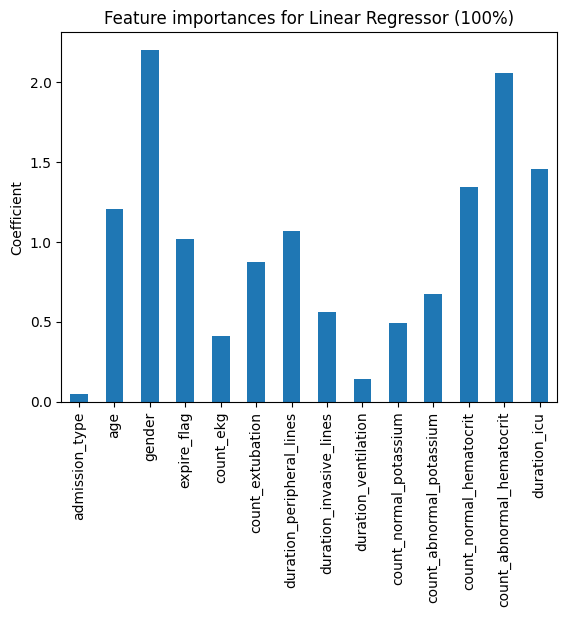

In [14]:
# Plot feature importances for linear regressor at 100%

feature_names = [feature for feature in list(train_features_100)]
importances = abs(lin_reg_100.coef_)[:14]

lin_reg_100_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
lin_reg_100_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for Linear Regressor (100%)")
ax.set_ylabel("Coefficient")

In [20]:
# Print feature importances for best performing RF classifier i.e. at 100% trace duration

rf_importances = rf_100.feature_importances_
attributes = list(train_features_100)

print("Feature importances for RF Classifier (100%) in descending order:-\n")
for ele in sorted(zip(rf_importances, attributes), reverse=True):
  print(ele)

Feature importances for RF Classifier (100%) in descending order:-

(0.14032355679277433, 'count_normal_hematocrit')
(0.11340663444852352, 'count_ekg')
(0.11002152001351445, 'admission_type')
(0.10943759962067172, 'count_extubation')
(0.09355770663620352, 'count_abnormal_potassium')
(0.09336988459601955, 'duration_invasive_lines')
(0.08315687131123325, 'duration_peripheral_lines')
(0.0461833995354012, 'count_normal_potassium')
(0.04356621893987694, 'gender')
(0.04034486786454659, 'duration_ventilation')
(0.02865740335460001, 'count_abnormal_hematocrit')
(0.026057840162053883, 'expire_flag')
(0.0228445089995765, 'duration_icu')
(0.01247860014739871, 'age')


Text(0, 0.5, 'Mean decrease in impurity')

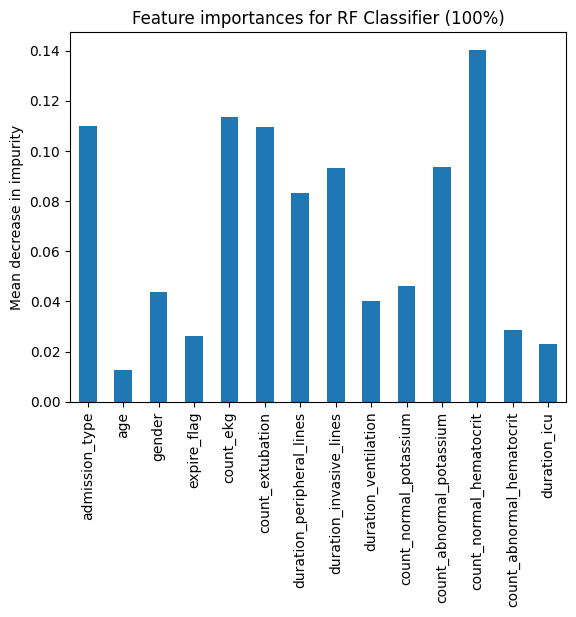

In [21]:
# Plot feature importances for RF classifier at 100%

feature_names = [feature for feature in list(train_features_100)]
importances = rf_100.feature_importances_[:14]

rf_100_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
rf_100_importances.plot.bar(ax=ax)
ax.set_title("Feature importances for RF Classifier (100%)")
ax.set_ylabel("Mean decrease in impurity")

### Saving Dataframes to Google Drive

In [ ]:
# Saving dataframes to Google Drive

cardiovascular.to_csv('cardiovascular.csv', index=False)
!cp cardiovascular.csv 'drive/My Drive/comp3931-sc20dpw'

filtered_cardiovascular.to_csv('filtered_cardiovascular.csv', index=False)
!cp filtered_cardiovascular.csv 'drive/My Drive/comp3931-sc20dpw'

admissions.to_csv('admissions.csv', index=False)
!cp admissions.csv 'drive/My Drive/comp3931-sc20dpw'

discharges.to_csv('discharges.csv', index=False)
!cp discharges.csv 'drive/My Drive/comp3931-sc20dpw'

procedures.to_csv('procedures.csv', index=False)
!cp procedures.csv 'drive/My Drive/comp3931-sc20dpw'

freq_procedures.to_csv('freq_procedures.csv', index=False)
!cp freq_procedures.csv 'drive/My Drive/comp3931-sc20dpw'

cont_procedures.to_csv('cont_procedures.csv', index=False)
!cp cont_procedures.csv 'drive/My Drive/comp3931-sc20dpw'

freq_cont_procedures.to_csv('freq_cont_procedures.csv', index=False)
!cp freq_cont_procedures.csv 'drive/My Drive/comp3931-sc20dpw'

labtests.to_csv('labtests.csv', index=False)
!cp labtests.csv 'drive/My Drive/comp3931-sc20dpw'

freq_labtests.to_csv('freq_labtests.csv', index=False)
!cp freq_labtests.csv 'drive/My Drive/comp3931-sc20dpw'

icustays.to_csv('icustays.csv', index=False)
!cp icustays.csv 'drive/My Drive/comp3931-sc20dpw'

event_log.to_csv('event_log.csv', index=False)
!cp event_log.csv 'drive/My Drive/comp3931-sc20dpw'

feature_data_0.to_csv('feature_data_0.csv', index=False)
!cp feature_data_0.csv 'drive/My Drive/comp3931-sc20dpw'

feature_data_25.to_csv('feature_data_25.csv', index=False)
!cp feature_data_25.csv 'drive/My Drive/comp3931-sc20dpw'

feature_data_50.to_csv('feature_data_50.csv', index=False)
!cp feature_data_50.csv 'drive/My Drive/comp3931-sc20dpw'

feature_data_75.to_csv('feature_data_75.csv', index=False)
!cp feature_data_75.csv 'drive/My Drive/comp3931-sc20dpw'

feature_data_100.to_csv('feature_data_100.csv', index=False)
!cp feature_data_100.csv 'drive/My Drive/comp3931-sc20dpw'

target_data.to_csv('target_data.csv', index=False)
!cp target_data.csv 'drive/My Drive/comp3931-sc20dpw'